<a href="https://colab.research.google.com/github/chandrakiranck/fuzzy-adventure/blob/master/ElectricMotor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### **Imports:**

We will use the standard data science and machine learning libraries: **numpy, pandas, and scikit-learn**. We also use **matplotlib and seaborn for visualization.**

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

## **Data Cleaning and Formatting**:

### **Load in the Data and Examine**:

We will be loading our data into a pandas dataframe, one of the most useful data structures for data science. Think of it as a spreadsheet within Python that we can easily manipulate, clean, and visualize. Pandas has many methods to help make the data science/machine learning pipeline as smooth as possible.

In [0]:
data=pd.read_csv("/content/drive/My Drive/electric-motor-temperature/pmsm_temperature_data.csv")

In [0]:
data.head()

## **Shape**

In [0]:
data.shape

### **List of Column**

In [0]:
# Count the column types
data.dtypes.value_counts()

In [0]:
list(data.columns)

In [0]:
data.info()

### **Columns Description**


**ambient** : Ambient temperature as measured by a thermal sensor located closely to the stator.


**coolan** :  Coolant temperature. The motor is water cooled. Measurement is taken at outflow.


**u_d** :  Voltage d-component


**u_q** : Voltage q-component


**motor_speed** : Motor speed


**torque** : Torque induced by current.


**i_d** : Current d-component


**i_q** : Current q-component



**pm** : Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.


**stator_yoke** : Stator yoke temperature measured with a thermal sensor.
**stator_tooth** : Stator tooth temperature measured with a thermal sensor.


**stator_winding** : Stator winding temperature measured with a thermal sensor.


**profile_id** : Each measurement session has a unique ID. Make sure not to try to estimate from one session onto the other as they are strongly independent

### **Detecting Null values**

In [0]:
data.isnull().sum()

No Null Values in data







### **Checking correlation between variables**

In [0]:
f,ax=plt.subplots(figsize=(12,12))
sns.heatmap(data.corr(), annot=True, linewidths=.5,  cmap="coolwarm", square=True, ax=ax)
plt.show()


*  from the above correlation map we came to know that most of the independent varaiables are srtongly  correlating with each other.

*   In the later stage of the model building we can use Feature Extraction techniques like PCA,or feature engineering .









KeyboardInterrupt: ignored

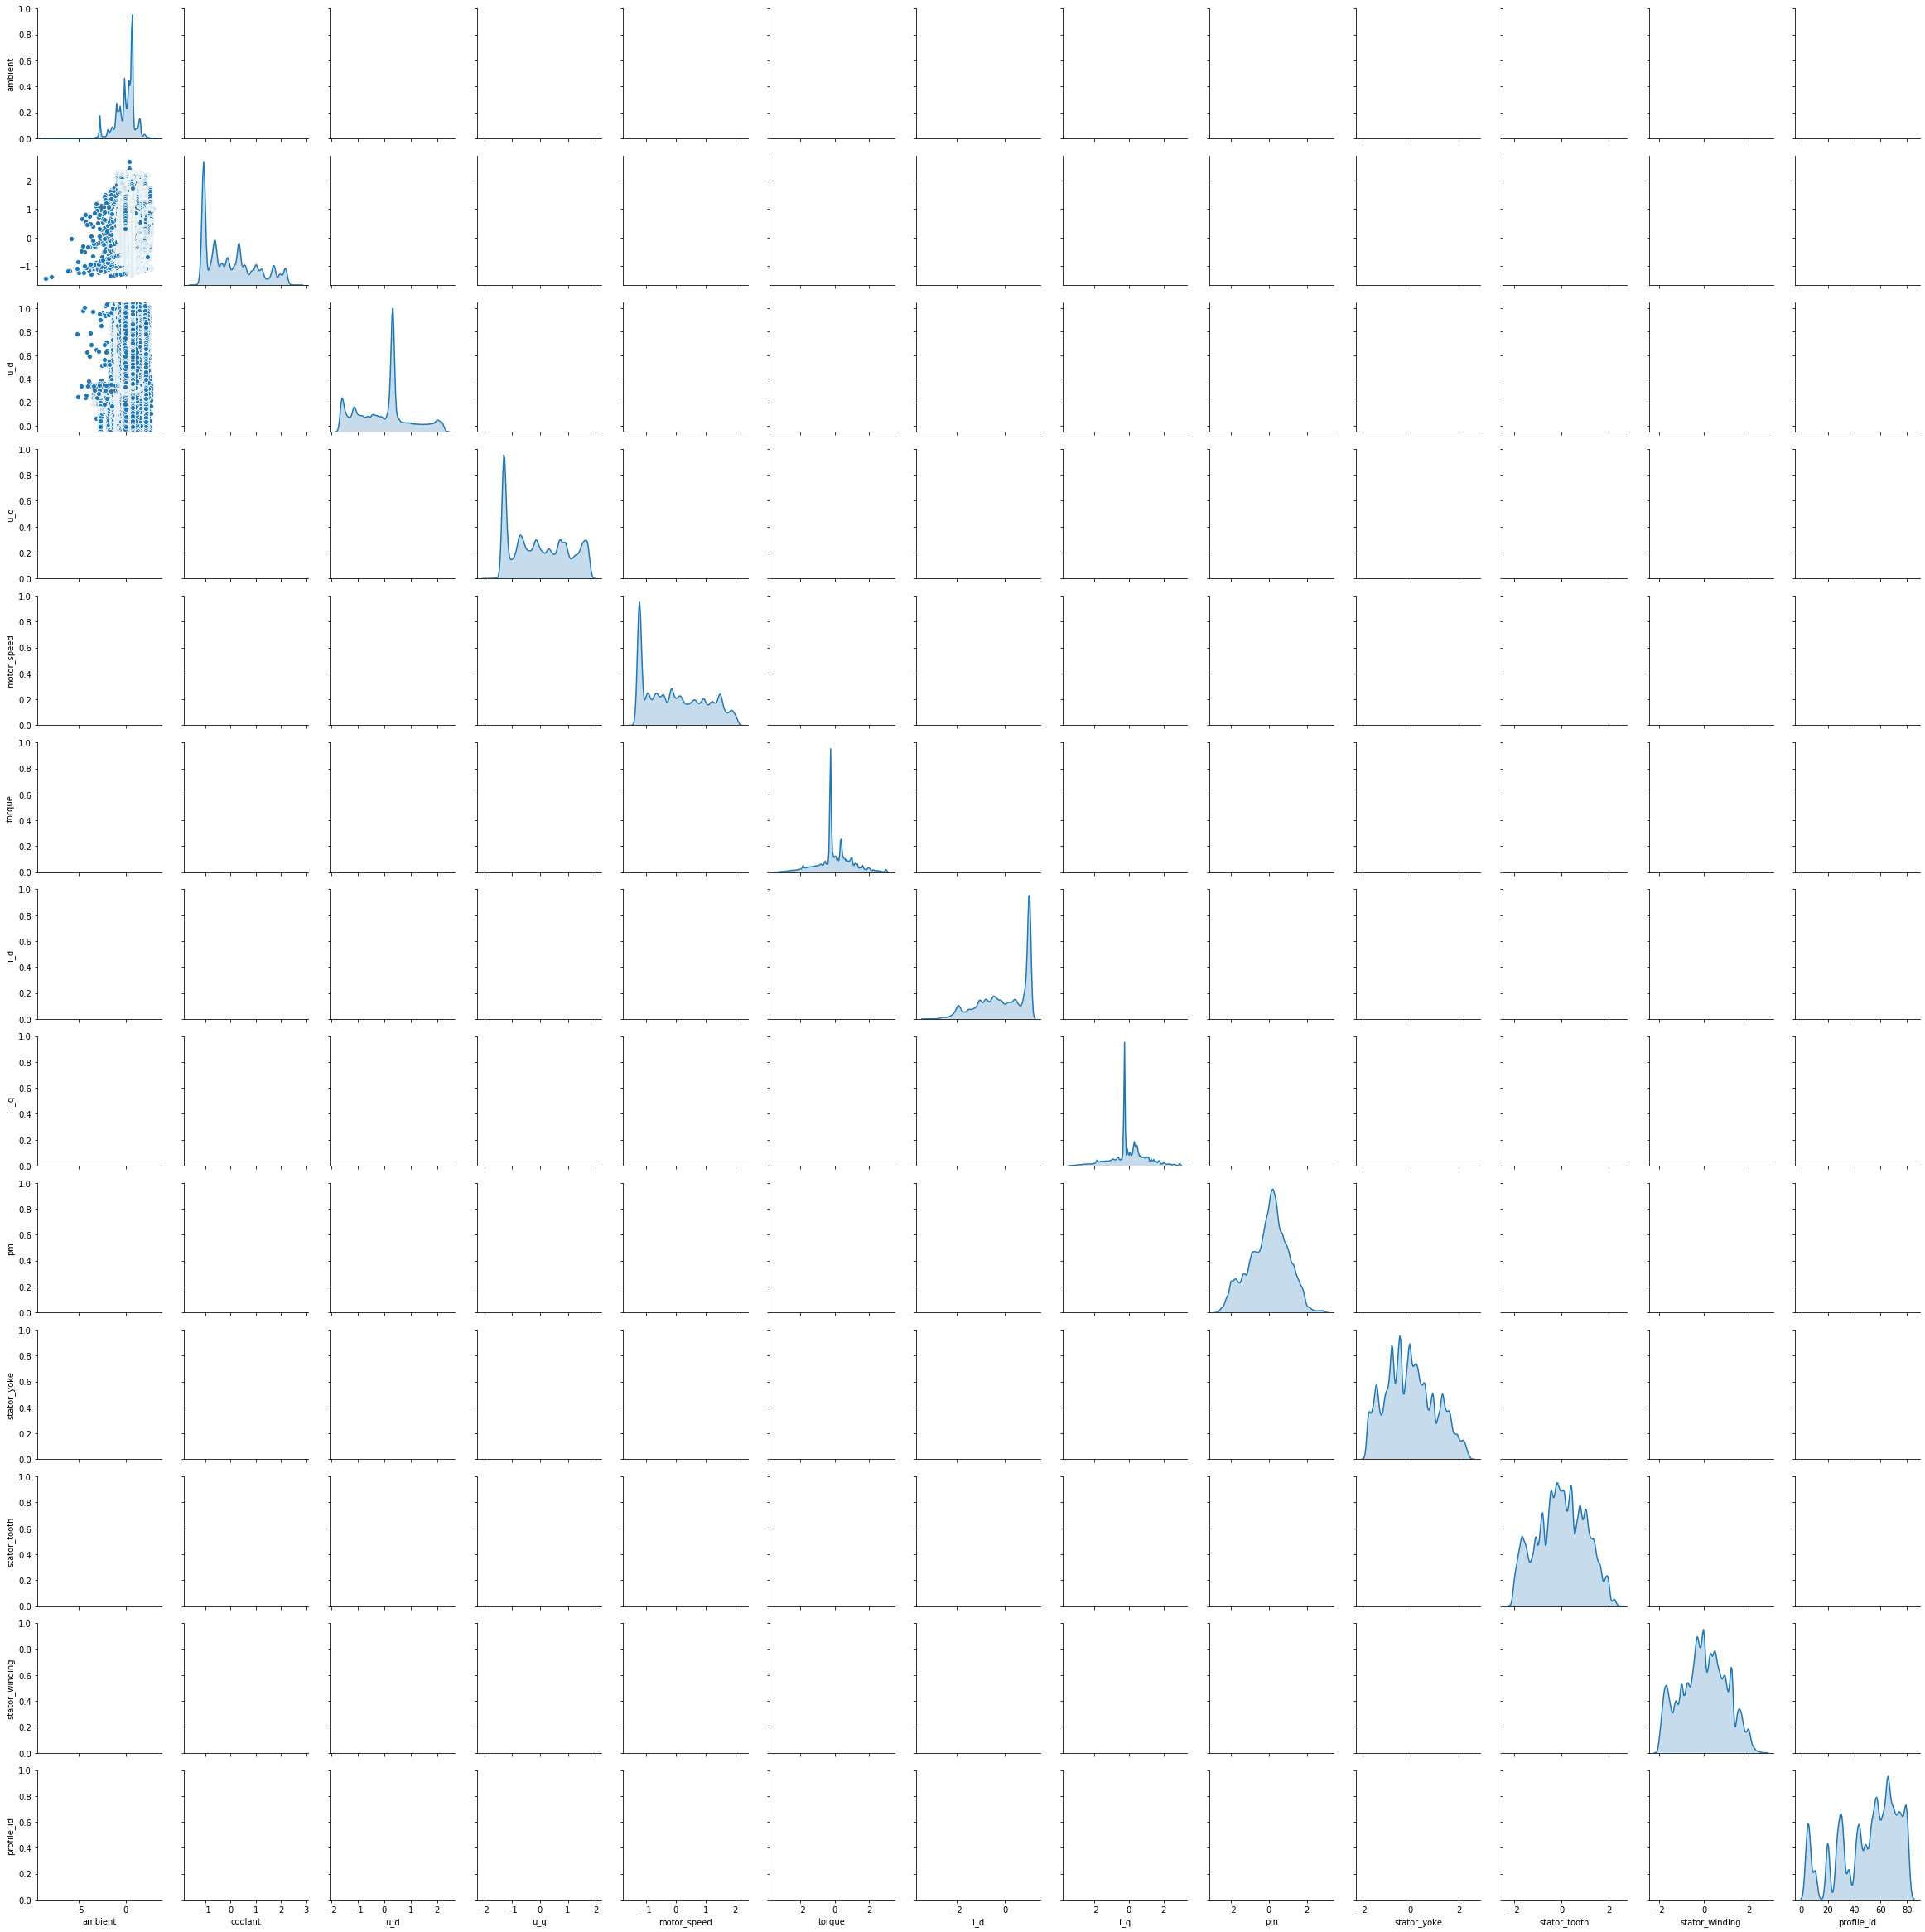

In [0]:
sns.pairplot(data,diag_kind="kde")

### **Exploratory Data Analysis**

For all the numerical columns

In [0]:
data.profile_id.value_counts().sum()

998070

In [0]:
data.drop(["profile_id"],axis=1,inplace=True)

In [0]:
numerical = data._get_numeric_data().columns
categorical = set(data.columns) - set(numerical)

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
       'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
      dtype='object')


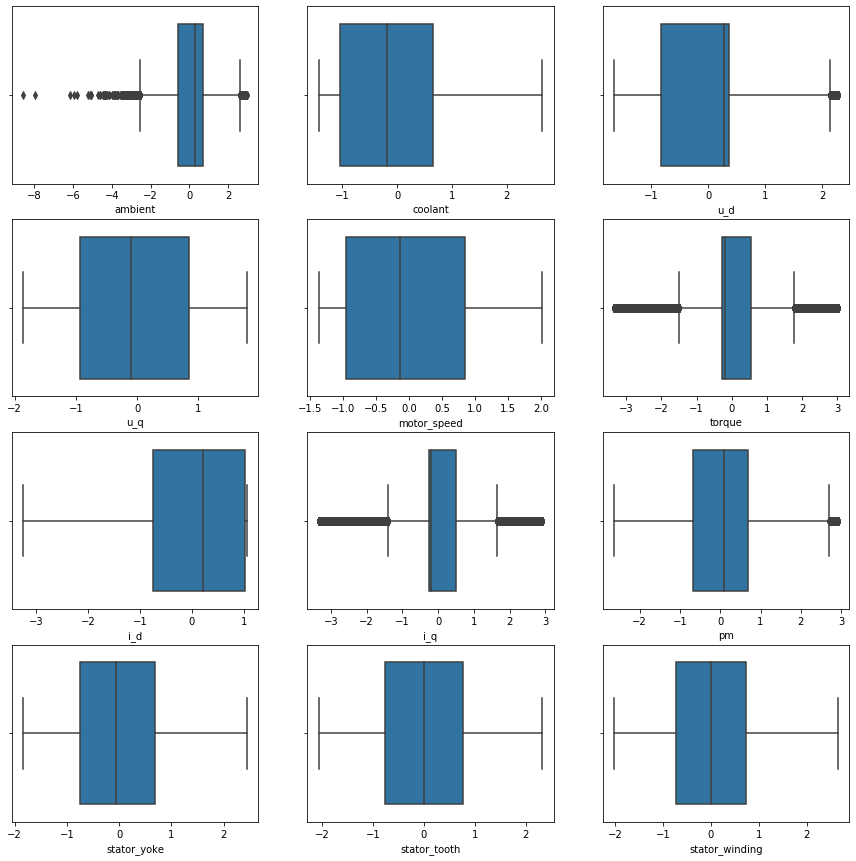

In [0]:
num_of_rows = 4
num_of_cols = 3
fig, ax = plt.subplots(num_of_rows, num_of_cols, figsize=(15,15))
print(numerical)
i=0;j=0;k=0;
while i<num_of_rows:
    while j<num_of_cols:
        sns.boxplot(data[numerical[k]], ax=ax[i, j])
        k+=1;j+=1
    j=0;i+=1

plt.show()

In the above plots we came to know that the for most of the varaibles having outliers , by using the capping technique I'm capping the data max...in the below...

In [0]:
lsUpper = []
lsLower = []
def removeOutliers(numerical):
    for i in range(len(numerical)):
        q1 = data[numerical[i]].quantile(0.25)
        q3 = data[numerical[i]].quantile(0.75)
        IQR = q3-q1
        minimum = q1 - 1.5 * IQR
        maximum = q3 + 1.5 * IQR
        data.loc[(data[numerical[i]] <= minimum), numerical[i]] = minimum
        data.loc[(data[numerical[i]] >= maximum), numerical[i]] = maximum  
removeOutliers(numerical)

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d',
       'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
      dtype='object')


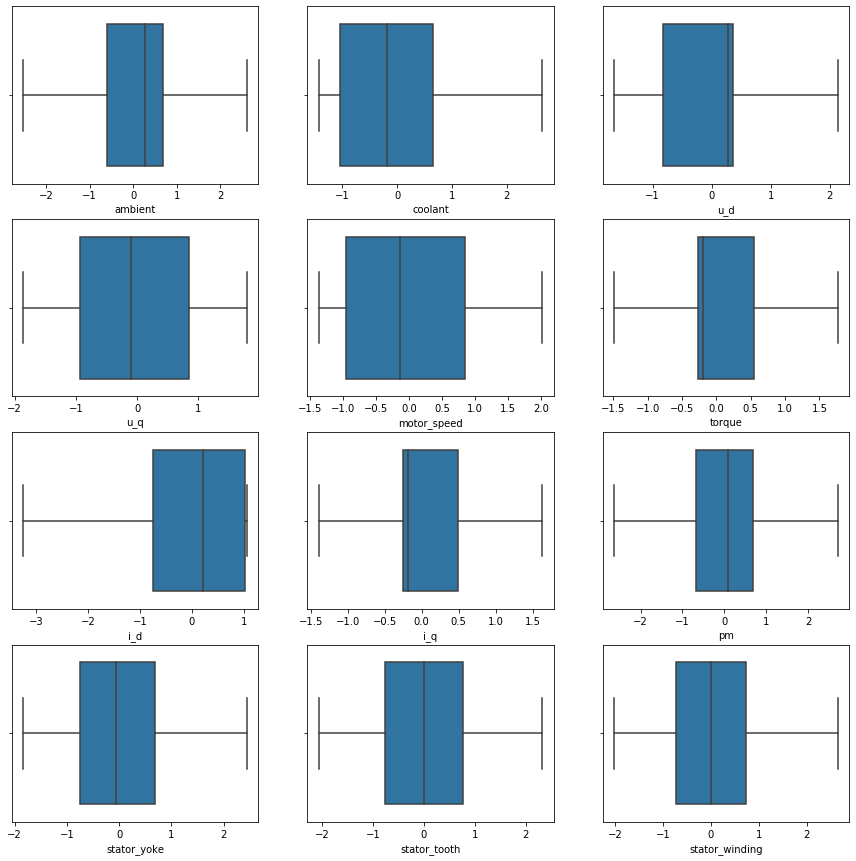

In [0]:
num_of_rows = 4
num_of_cols = 3
fig, ax = plt.subplots(num_of_rows, num_of_cols, figsize=(15,15))
print(numerical)
i=0;j=0;k=0;
while i<num_of_rows:
    while j<num_of_cols:
        sns.boxplot(data[numerical[k]], ax=ax[i, j])
        k+=1;j+=1
    j=0;i+=1
plt.savefig('after_removing_outliers_from_numerical_columns.png')
plt.show()

In the avove **pairplot** we came know that the data is not normally distributed,so I'm doing **scaling to normalize the data** and from the **heat map** we came to know that the **independent varaibles are highly correlating each other** (high multicollinearity) by using **Principal component analysis (PCA) will reduce the correlation between variables**.

In [0]:
#Defining dependet and independent variable
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X = data.drop(["motor_speed"],axis=1)
y = data['motor_speed']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=0)
model=LinearRegression()
mm=MinMaxScaler()
x_train=mm.fit_transform(x_train,y)
x_test=mm.transform(x_test)
model.fit(x_train,y_train)
print('Training score =', model.score(x_train, y_train))
print('Test score =', model.score(x_test, y_test))

Training score = 0.9379563593231633
Test score = 0.9380924002089138


In [0]:
model.intercept_

1.9338937546998076

In [0]:
y_train_pred=model.predict(x_train)
print('R2 of train data:',r2_score(y_train,y_train_pred))

y_test_pred=model.predict(x_test)
print('R2 of test data:',r2_score(y_test,y_test_pred))

R2 of train data: 0.9379563593231633
R2 of test data: 0.9380924002089139


In [0]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test,y_test_pred)
r_squared = r2_score(y_test,y_test_pred)
print("RMSE",np.sqrt(mse))
print("mse",mse)
print("r_squared",r_squared)

RMSE 0.24934610816963065
mse 0.06217348165934115
r_squared 0.9380924002089139


In [0]:
pd.DataFrame(y_test_pred).to_csv("predicted.csv",index=False)

**Checking Assumptions for Regression:**

*      There should be a linear and additive relationship between dependent (response) variable and independent (predictor) variable(s). A linear relationship suggests that a change in response Y due to one unit change in X¹ is constant, regardless of the value of X¹. An additive relationship suggests that the effect of X¹ on Y is independent of other variables.


*      There should be no correlation between the residual (error) terms. Absence of this phenomenon is known as Autocorrelation.

**How to check:** Look for **Durbin – Watson (DW) statistic**. It must lie between 0 and 4. If DW = 2, implies no autocorrelation, 0 < DW < 2 implies positive autocorrelation while 2 < DW < 4 indicates negative autocorrelation. Also, you can see residual vs time plot and look for the seasonal or correlated pattern in residual values

*      The independent variables should not be correlated. Absence of this phenomenon is known as multicollinearity.

**How to check:** You can use scatter plot to visualize correlation effect among variables. Also, you can also use VIF factor. VIF value <= 4 suggests no multicollinearity whereas a value of >= 10 implies serious multicollinearity. Above all, a correlation table should also solve the purpose.

*      The error terms must have constant variance. This phenomenon is known as homoskedasticity. The presence of non-constant variance is referred to heteroskedasticity.

**How to check:**You can look at residual vs fitted values plot. If heteroskedasticity exists, the plot would exhibit a funnel shape pattern (shown in next section). Also, you can use Breusch-Pagan / Cook – Weisberg test or White general test to detect this phenomenon.

*        The error terms must be normally distributed.

**How to check:**You can look at QQ plot (shown below). You can also perform statistical tests of normality such as Kolmogorov-Smirnov test, Shapiro-Wilk test.
 

In [0]:
import statsmodels.api as sm
x_constant = sm.add_constant(X)
lin_reg=sm.OLS(y,x_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            motor_speed   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.373e+06
Date:                Tue, 24 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:16:30   Log-Likelihood:                -29812.
No. Observations:              998070   AIC:                         5.965e+04
Df Residuals:                  998058   BIC:                         5.979e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0093      0.000     37.287      0.000       0.009       0.010
ambient           -0.0488      0.000   -150.384      0.000      -0.049      -0.048
coolant            0.3299      0.002    210.004      0.000       0.327       0.333
u_d               -0.2585      0.001   -446.740      0.000      -0.260      -0.257
u_q                0.5416      0.000   1783.044      0.000       0.541       0.542
torque            -0.1875      0.004    -47.060      0.000      -0.195      -0.180
i_d               -0.6467      0.000  -1487.724      0.000      -0.648      -0.646
i_q               -0.1793      0.004    -46.427      0.000      -0.187      -0.172
pm                 0.0962      0.001    186.536      0.000       0.095       0.097
stator_yoke       -1.3300      0.005   -274.592      0.000      -1.339      -1.321
stator_tooth       1.9178      0.006    300.266      0.000       1.905       1.930
stator_winding    -0.9835      0.003   -312.334      0.000      -0.990      -0.977
==============================================================================
Omnibus:                    51791.205   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           199643.437
Skew:                          -0.076   Prob(JB):                         0.00
Kurtosis:                       5.186   Cond. No.                         69.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

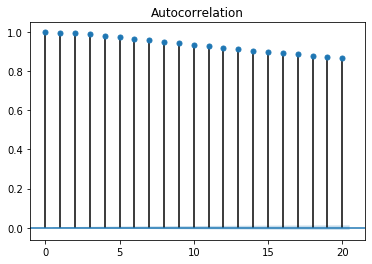

In [0]:
import statsmodels.tsa.api as smt
acf=smt.graphics.plot_acf(lin_reg.resid,lags=20,alpha=0.05)
acf.show()

(199643.43703880985, 0.0)


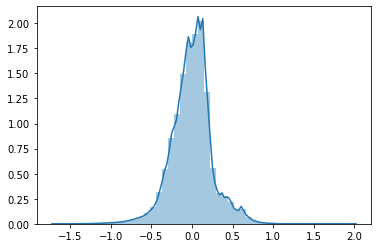

In [0]:
from scipy import stats

print(stats.jarque_bera(lin_reg.resid))

sns.distplot(lin_reg.resid)

In [0]:
from scipy import stats
print(stats.jarque_bera(lin_reg.resid))

(199643.43703880985, 0.0)


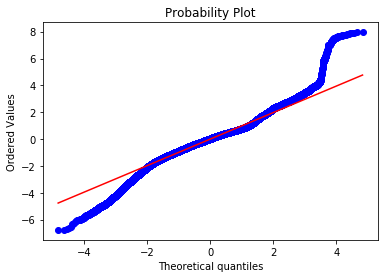

In [0]:
import statsmodels.api as sm
sm.stats.diagnostic.linear_rainbow(res=lin_reg, frac=0.5)

import scipy.stats as stats
import pylab
from statsmodels.graphics.gofplots import ProbPlot
st_residual = lin_reg.get_influence().resid_studentized_internal
stats.probplot(st_residual, dist="norm", plot = pylab)
plt.show()

In [0]:
lin_reg.resid.mean()

1.300399566801201e-15

KeyboardInterrupt: ignored

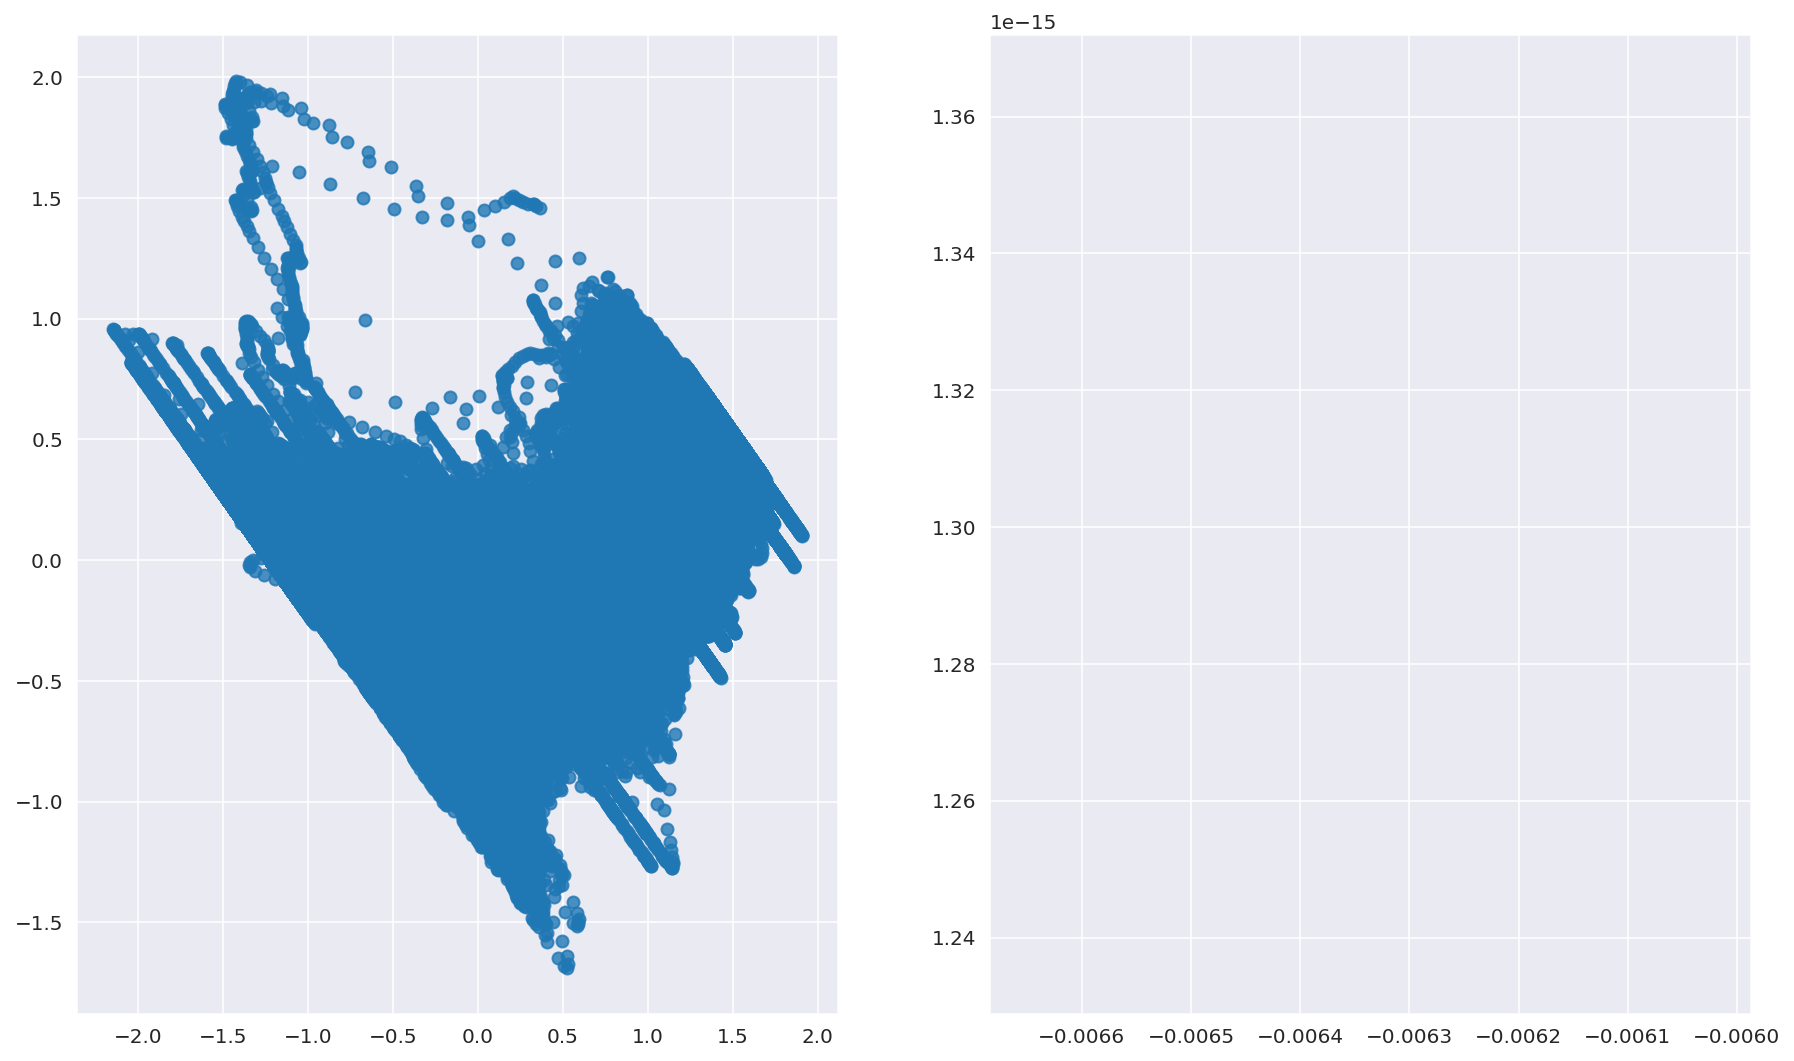

In [0]:
from statsmodels.compat import lzip
import numpy as np
from statsmodels.compat import lzip
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

model = lin_reg
fitted_vals = model.predict()
resids = model.resid
resids_standardized = model.get_influence().resid_studentized_internal
fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Residuals vs Fitted', fontsize=16)
ax[0].set(xlabel='Fitted Values', ylabel='Residuals')
sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')



In [0]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)

[('F statistic', 0.9640848056006798), ('p-value', 0.9999999999999999)]

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(x_constant.values, i) for i in range(x_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,ambient,coolant,u_d,u_q,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
vif,1.581127,39.819893,5.327801,1.48826,185.507166,3.028502,163.048281,4.227846,377.505445,654.535899,158.692989


In [0]:
# removing collinear variables
# function definition

def calculate_vif(x):
    thresh = 5.0
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, j) for j in range(x.shape[1])]
    for i in range(1,k):
        print("Iteration no.")
        print(i)
        print(vif)
        a = np.argmax(vif)
        print("Max VIF is for variable no.:")
        print(a)
        if vif[a] <= thresh :
            break
        if i == 1 :          
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1 :
            output = output.drop(output.columns[a],axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

In [0]:
X_train = calculate_vif(X)

Iteration no.
1
[1.5810864319775908, 39.81568087407625, 5.322007933048702, 1.4878998102900525, 185.40660634076, 3.0277184195800526, 162.88397380528693, 4.227915687746697, 377.4182668950973, 654.3305259535279, 158.64135259152386]
Max VIF is for variable no.:
9
Iteration no.
2
[1.5800117773682238, 27.387074795964296, 4.924648505733052, 1.2111281150762834, 183.9144848128827, 3.0269133092759137, 162.6560963631792, 3.4120314634981517, 84.67800531744986, 30.248570560720854]
Max VIF is for variable no.:
4
Iteration no.
3
[1.579968028669933, 27.352469889575534, 4.103258131861616, 1.1226724928131813, 2.845856532191936, 3.89741848596644, 3.402401105139178, 84.57218877714693, 30.16648731758564]
Max VIF is for variable no.:
7
Iteration no.
4
[1.5775543731346038, 2.094782477871304, 4.103246298285218, 1.0511902078339728, 2.2075250663893398, 3.896783774967511, 2.9042298144677376, 4.336739067529742]
Max VIF is for variable no.:
7


In [0]:
X_train.head()

,ambient,coolant,u_d,u_q,i_d,i_q,pm,stator_winding
0,-0.752143,-1.118446,0.327935,-1.297858,1.029572,-0.245860,-2.522071,-2.018033
1,-0.771263,-1.117021,0.329665,-1.297686,1.029509,-0.245832,-2.522418,-2.017631
2,-0.782892,-1.116681,0.332771,-1.301822,1.029448,-0.245818,-2.522673,-2.017343
3,-0.780935,-1.116764,0.333700,-1.301852,1.032845,-0.246955,-2.521639,-2.017632
4,-0.774043,-1.116775,0.335206,-1.303118,1.031807,-0.246610,-2.521900,-2.018145


### Decision Tree Regression

In [0]:
from sklearn.tree import DecisionTreeRegressor
DTree=DecisionTreeRegressor(min_samples_leaf=.0001)
DTree.fit(x_train,y_train)
y_predict=DTree.predict(x_test)
from sklearn.metrics import r2_score
print('Training score =', DTree.score(x_train, y_train))
print('Test score =', DTree.score(x_test, y_test))


Training score = 0.9990629188485916
Test score = 0.9989693512454615


### Random Forest Regression

In [0]:
from sklearn.ensemble import RandomForestRegressor
RForest=RandomForestRegressor(n_estimators=50,random_state=0,min_samples_leaf=.0001)
RForest.fit(x_train,y_train)
y_predict=RForest.predict(x_test)
from sklearn.metrics import r2_score
r2_score=r2_score(y_test,y_predict)
mse = mean_squared_error(y_test,y_predict)
print("RMSE",np.sqrt(mse))
print("mse",mse)
print('Training score =', RForest.score(x_train, y_train))
print('Test score =', RForest.score(x_test, y_test))


RMSE 0.028979820207692894
mse 0.0008398299792702053
Training score = 0.9991930508941513
Test score = 0.9991637615127604


In [0]:
model=LinearRegression()
mm=MinMaxScaler()
x_train=mm.fit_transform(x_train,y)
x_test=mm.transform(x_test)
model.fit(x_train,y_train)
print('Training score =', model.score(x_train, y_train))
print('Test score =', model.score(x_test, y_test))

Training score = 0.9379563593231633
Test score = 0.9380924002089138
